In [1]:
import numpy as np
import matplotlib.pyplot as plt

import sklearn
%config Completer.use_jedi = False
#Command to stop autocompletion from taking eternity

### List of names of classes

In [2]:
classes_names_indiana_pines = ["Alfalfa", "Corn-notill", 
"Corn-mintill", "Corn", "Grass-pasture", "Grass-trees",
"Grass-pasture-mowed", "Hay-windrowed", "Oats", "Soybean-notill",
"Soybean-mintill", "Soybean-clean", "Wheat", "Woods", 
"Buildings-grass-Trees-Drives", "Stone-Steel-Towers"]

classes_names_salinas = ["Brocoli_green_weeds_1", 
"Brocoli_green_weeds_2", "Fallow", "Fallow_rough_plow", 
"Fallow_smooth", "Stubble", "Celery", "Grapes_untrained",
"Soil_vinyard_develop", "Corn_senesced_green_weeds", "Lettuce_romaine_4wk", 
"Lettuce_romaine_5wk", "Lettuce_romaine_6wk", "Lettuce_romaine_7wk", 
"Vinyard_untrained", "Vinyard_vertical_trellis"]

### Load and Display Images

In [3]:
salinas = np.load('salinas.npy', allow_pickle=True)
salinas_gt = np.load('salinas_gt.npy', allow_pickle=True)
print(salinas.shape)
print(salinas_gt.shape)

(512, 217, 204)
(512, 217)


In [4]:
indiana_pines = np.load('indianapines.npy', allow_pickle=True)
indiana_pines_gt = np.load('indianapines_gt.npy', allow_pickle=True)
print(indiana_pines.shape)
print(indiana_pines_gt.shape)

(145, 145, 200)
(145, 145)


In [5]:
def plot_RGB(image):
    imageRGB = np.array(image[:, :, [30, 15, 2]], dtype=float)

    pmin,pmax = np.percentile(imageRGB, (1,99), axis=(0,1))
    print(pmin, pmax)
    imageRGB_pimped = imageRGB.copy()

    for i in range(pmin.size):
        imageRGB_pimped[:,:,i] = (imageRGB[:,:,i] - pmin[i]) / (pmax[i] - pmin[i])

    imageRGB_pimped[imageRGB_pimped < 0] = 0
    imageRGB_pimped[imageRGB_pimped > 1] = 1

    plt.figure(figsize=(5,5))
    plt.imshow(imageRGB_pimped)
    plt.show()

[ 600. 1045.  474.] [3747. 3107.  927.]


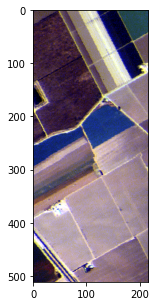

In [6]:
plot_RGB(salinas)

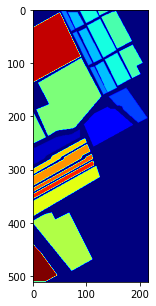

In [7]:
plt.figure(figsize=(5,5))
plt.imshow(salinas_gt, cmap='jet')

[2353. 2761. 3833.] [5442.   6051.76 4946.  ]


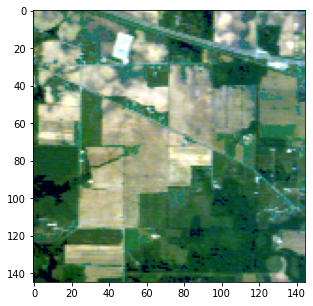

In [8]:
plot_RGB(indiana_pines)

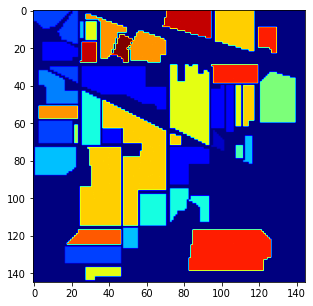

In [9]:
plt.figure(figsize=(5,5))
plt.imshow(indiana_pines_gt, cmap='jet')

### Remove 0's

In [10]:
def flatten_image(X):
    return X.reshape((-1, X.shape[-1]))

X1 = flatten_image(salinas)
Y1 = salinas_gt.flatten()

X1 = X1[Y1!=0]
Y1 = Y1[Y1!=0]
Y1 = Y1 - 1
values, count = np.unique(Y1, return_counts=True)
print(values, '\n', count)
print(X1.shape)
print(Y1.shape)

X2 = flatten_image(indiana_pines)
Y2 = indiana_pines_gt.flatten()

X2 = X2[Y2!=0]
Y2 = Y2[Y2!=0]
Y2 = Y2 - 1
print(X2.shape)
print(Y2.shape)

[ 0  1  2  3  4  5  6  7  8  9 10 11 12 13 14 15] 
 [ 2009  3726  1976  1394  2678  3959  3579 11271  6203  3278  1068  1927
   916  1070  7268  1807]
(54129, 204)
(54129,)
(10249, 200)
(10249,)


In [105]:
from sklearn.utils import class_weight
def class_weights(y):
    class_weights = class_weight.compute_class_weight('balanced', classes=np.unique(y), y=y)
    class_weights = dict(zip(np.arange(17), class_weights))

    print(class_weights)

    return class_weights

class_weights1 = class_weights(Y1)
class_weights2 = class_weights(Y2)



{0: 1.6839534594325536, 1: 0.9079609500805152, 2: 1.7120761639676114, 3: 2.4268741032998564, 4: 1.263279499626587, 5: 0.8545245011366507, 6: 0.945253562447611, 7: 0.3001563747671014, 8: 0.5453913428985975, 9: 1.032050793166565, 10: 3.1676615168539324, 11: 1.7556110534509601, 12: 3.6932996724890828, 13: 3.1617406542056075, 14: 0.4654736516235553, 15: 1.8721983951300498}
{0: 13.925271739130435, 1: 0.4485731792717087, 2: 0.771762048192771, 3: 2.702795358649789, 4: 1.3262163561076605, 5: 0.8774828767123287, 6: 22.877232142857142, 7: 1.3400889121338913, 8: 32.028125, 9: 0.6590149176954733, 10: 0.2609215885947047, 11: 1.0802065767284992, 12: 3.1246951219512193, 13: 0.5063735177865613, 14: 1.659488341968912, 15: 6.887768817204301}


### Split in test set

In [11]:
from sklearn.model_selection import train_test_split
X1_train, X1_test, Y1_train, Y1_test = train_test_split(X1, Y1, test_size=0.2, random_state=1, stratify=Y1)
X2_train, X2_test, Y2_train, Y2_test = train_test_split(X2, Y2, test_size=0.2, random_state=1, stratify=Y2)
print(X1_train.shape)

(43303, 204)


### Classifier

In [12]:
from sklearn.svm import SVC

In [181]:
from sklearn.multiclass import OneVsRestClassifier
from sklearn.preprocessing import StandardScaler, Normalizer
from sklearn.pipeline import make_pipeline, Pipeline
from sklearn.decomposition import PCA
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
from sklearn.discriminant_analysis import QuadraticDiscriminantAnalysis

In [135]:
pipe_salinas = Pipeline([('lda', LinearDiscriminantAnalysis()),
                         ('svc', SVC(C=1.4, max_iter=600, gamma=0.05, class_weight=None, verbose=1, random_state=42))])

In [123]:
pipe_indianas = Pipeline([('lda', LinearDiscriminantAnalysis()),
                         ('svc', SVC(C=1.4, max_iter=600, gamma=0.05, class_weight=None, verbose=1, random_state=42))])

### Fit

In [138]:
%%time
pipe_salinas.fit(X1_train, Y1_train)
pipe_salinas.score(X1_test, Y1_test)

[LibSVM]

/home/pernin/.local/lib/python3.6/site-packages/sklearn/svm/_base.py:258: ConvergenceWarning: Solver terminated early (max_iter=600).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  % self.max_iter, ConvergenceWarning)


CPU times: user 15.4 s, sys: 3.37 s, total: 18.8 s
Wall time: 10.6 s


0.892111583225568

In [124]:
%%time
pipe_indianas.fit(X2_train, Y2_train)
pipe_indianas.score(X2_test, Y2_test)

[LibSVM]

/home/pernin/.local/lib/python3.6/site-packages/sklearn/svm/_base.py:258: ConvergenceWarning: Solver terminated early (max_iter=600).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  % self.max_iter, ConvergenceWarning)


CPU times: user 2.39 s, sys: 1.73 s, total: 4.12 s
Wall time: 1.73 s


0.8765853658536585

In [32]:
pipe_salinas.get_params().keys()

dict_keys(['memory', 'steps', 'verbose', 'scaler', 'pca', 'svc', 'scaler__copy', 'scaler__with_mean', 'scaler__with_std', 'pca__copy', 'pca__iterated_power', 'pca__n_components', 'pca__random_state', 'pca__svd_solver', 'pca__tol', 'pca__whiten', 'svc__C', 'svc__break_ties', 'svc__cache_size', 'svc__class_weight', 'svc__coef0', 'svc__decision_function_shape', 'svc__degree', 'svc__gamma', 'svc__kernel', 'svc__max_iter', 'svc__probability', 'svc__random_state', 'svc__shrinking', 'svc__tol', 'svc__verbose'])

In [129]:
%%time

from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import RandomizedSearchCV
from sklearn.model_selection import StratifiedKFold
# explicitly require this experimental feature
from sklearn.experimental import enable_halving_search_cv # noqa
# now you can import normally from model_selection
from sklearn.model_selection import HalvingGridSearchCV
pipe = pipe_salinas

grid_params = {
    # Key = step name from pipeline + __ + hyperparameter, value = tuple of possible values
    #'scaler__with_mean': [False, True],
    #'scaler__with_std': [False, True],
    #'svc__class_weight': [None, 'balanced'],
    'svc__max_iter': [100,200,300,400,500,600,700,800,900],
    #'svc__kernel': ['linear', 'poly', 'rbf', 'sigmoid'],
    #'pca__n_components': [None, 5, 10, 20, 40, 50],
    #'svc__C': [1.4, 1.6, 1.8],
    'svc__gamma': ['scale', 0.1, 0.03, 0.08, 1, 0.5, 0.05]
}

cv = StratifiedKFold(n_splits=3)
# Instantiate new gridsearch object
# gs = GridSearchCV(estimator=pipe, param_grid=grid_params, cv=cv, n_jobs=6, verbose=4)
#gs = RandomizedSearchCV(estimator=pipe, param_distributions=grid_params, n_iter=10, cv=cv, n_jobs=6, verbose=4)
gs = HalvingGridSearchCV(estimator=pipe, param_grid=grid_params, cv=cv, n_jobs=6, verbose=1, min_resources=len(X1_train) // 4)
# Fit model to our training data
gs.fit(X1_train, Y1_train)

# Score the model on our testing data
gs.score(X1_test, Y1_test)


n_iterations: 2
n_required_iterations: 4
n_possible_iterations: 2
min_resources_: 10825
max_resources_: 43303
aggressive_elimination: False
factor: 3
----------
iter: 0
n_candidates: 63
n_resources: 10825
Fitting 3 folds for each of 63 candidates, totalling 189 fits
----------
iter: 1
n_candidates: 21
n_resources: 32475
Fitting 3 folds for each of 21 candidates, totalling 63 fits
[LibSVM]

/home/pernin/.local/lib/python3.6/site-packages/sklearn/svm/_base.py:258: ConvergenceWarning: Solver terminated early (max_iter=900).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  % self.max_iter, ConvergenceWarning)


CPU times: user 27.3 s, sys: 5.49 s, total: 32.8 s
Wall time: 4min 53s


0.8734527988176611

In [127]:
%%time
pipe = pipe_indianas
grid_params = {
    #'scaler__with_mean': [False, True],
    #'scaler__with_std': [False, True],
    #'svc__class_weight': [None, 'balanced'],
    'svc__max_iter': [100,200,300,400,500,600,700,800,900],
    #'svc__kernel': ['linear', 'poly', 'rbf', 'sigmoid'],
    #'pca__n_components': [None, 5, 10, 20, 40, 50],
    #'svc__C': [1.4, 1.6, 1.8],
    #'svc__gamma': ['scale', 0.1, 0.03, 0.08, 1, 0.5, 0.05]
}

cv = StratifiedKFold(n_splits=3)
gs = HalvingGridSearchCV(estimator=pipe, param_grid=grid_params, cv=cv, n_jobs=6, verbose=4, min_resources=len(X2_train) // 4)

gs.fit(X2_train, Y2_train)

gs.score(X2_test, Y2_test)

n_iterations: 2
n_required_iterations: 3
n_possible_iterations: 2
min_resources_: 2049
max_resources_: 8199
aggressive_elimination: False
factor: 3
----------
iter: 0
n_candidates: 9
n_resources: 2049
Fitting 3 folds for each of 9 candidates, totalling 27 fits
----------
iter: 1
n_candidates: 3
n_resources: 6147
Fitting 3 folds for each of 3 candidates, totalling 9 fits
[LibSVM]

/home/pernin/.local/lib/python3.6/site-packages/sklearn/svm/_base.py:258: ConvergenceWarning: Solver terminated early (max_iter=800).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  % self.max_iter, ConvergenceWarning)


CPU times: user 2.47 s, sys: 1.64 s, total: 4.1 s
Wall time: 6.02 s


0.8760975609756098

In [96]:
import pandas as pd
df = pd.DataFrame(gs.cv_results_)
df

,iter,n_resources,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_svc__C,param_svc__class_weight,param_svc__gamma,param_svc__max_iter,...,split1_test_score,split2_test_score,mean_test_score,std_test_score,rank_test_score,split0_train_score,split1_train_score,split2_train_score,mean_train_score,std_train_score
0,0,2049,0.147750,0.008532,0.048160,0.000766,0.8,None,scale,100,...,0.715959,0.743777,0.747194,0.027006,46,0.907760,0.912884,0.907028,0.909224,0.002605
1,0,2049,0.229089,0.014293,0.053047,0.003185,0.8,None,0.1,100,...,0.698389,0.699854,0.710591,0.016231,96,0.951684,0.962665,0.948023,0.954124,0.006221
2,0,2049,0.149590,0.014691,0.046736,0.002199,0.8,None,0.03,100,...,0.717423,0.743777,0.750122,0.029630,37,0.920205,0.931186,0.920205,0.923865,0.005176
3,0,2049,0.198949,0.012916,0.053530,0.004382,0.8,None,0.08,100,...,0.699854,0.714495,0.724256,0.024885,74,0.950220,0.954612,0.945827,0.950220,0.003586
4,0,2049,0.274493,0.007825,0.074189,0.001044,0.8,None,1,100,...,0.316252,0.327965,0.333821,0.017241,134,0.984627,0.980234,0.965593,0.976818,0.008137
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
145,1,6147,0.451663,0.005154,0.231624,0.003570,1.8,None,0.03,100,...,0.815520,0.797950,0.804946,0.007606,13,0.868960,0.889946,0.871157,0.876688,0.009418
146,1,6147,0.423372,0.009164,0.274250,0.036415,1.6,None,0.03,100,...,0.794046,0.813080,0.808199,0.010167,10,0.891410,0.866276,0.888238,0.881975,0.011176
147,1,6147,0.438854,0.013308,0.225039,0.012975,3,None,0.03,100,...,0.814544,0.816008,0.817472,0.003163,5,0.897511,0.894583,0.896291,0.896128,0.001201
148,1,6147,0.429408,0.016174,0.233402,0.008777,1.4,None,0.03,100,...,0.807223,0.805271,0.803807,0.003542,14,0.863104,0.872621,0.881406,0.872377,0.007474


In [130]:
print(gs.best_params_)

{'svc__gamma': 0.1, 'svc__max_iter': 900}


In [259]:
from sklearn.tree import plot_tree
plt.figure(figsize=(15,15))
plot_tree(clf, class_names=classes_names_salinas)
plt.show()

KeyboardInterrupt: 

### Testing

In [36]:
from sklearn.metrics import plot_confusion_matrix, classification_report

In [37]:
def plot_classification_and_confusion_matrix(clf, X_test, Y_test, class_names):
    print(clf.score(X_test, Y_test))
    print(classification_report(Y_test, clf.predict(X_test), target_names=class_names))

    fig, ax = plt.subplots(figsize=(25, 10))
    plot_confusion_matrix(clf, X_test, Y_test, ax=ax, display_labels=class_names)
    plt.show()

In [160]:
def plot_classification_and_confusion_matrix_from_prediction(Y_true, Y_pred, class_names):
    print(accuracy_score(Y_true, Y_pred))
    print(classification_report(Y_true, Y_pred, target_names=class_names))

    cm = confusion_matrix(Y_true, Y_pred)#, labels=classes_names_salinas)
    
    disp = ConfusionMatrixDisplay(confusion_matrix=cm,
                              display_labels=class_names)
    disp.plot()

0.892111583225568
                           precision    recall  f1-score   support

    Brocoli_green_weeds_1       1.00      1.00      1.00       402
    Brocoli_green_weeds_2       1.00      1.00      1.00       745
                   Fallow       1.00      1.00      1.00       395
        Fallow_rough_plow       1.00      0.99      0.99       279
            Fallow_smooth       0.99      1.00      0.99       536
                  Stubble       1.00      1.00      1.00       792
                   Celery       1.00      1.00      1.00       716
         Grapes_untrained       0.79      0.66      0.72      2254
     Soil_vinyard_develop       1.00      1.00      1.00      1241
Corn_senesced_green_weeds       0.99      0.99      0.99       656
      Lettuce_romaine_4wk       1.00      0.99      1.00       213
      Lettuce_romaine_5wk       0.99      1.00      1.00       385
      Lettuce_romaine_6wk       1.00      1.00      1.00       183
      Lettuce_romaine_7wk       1.00      0

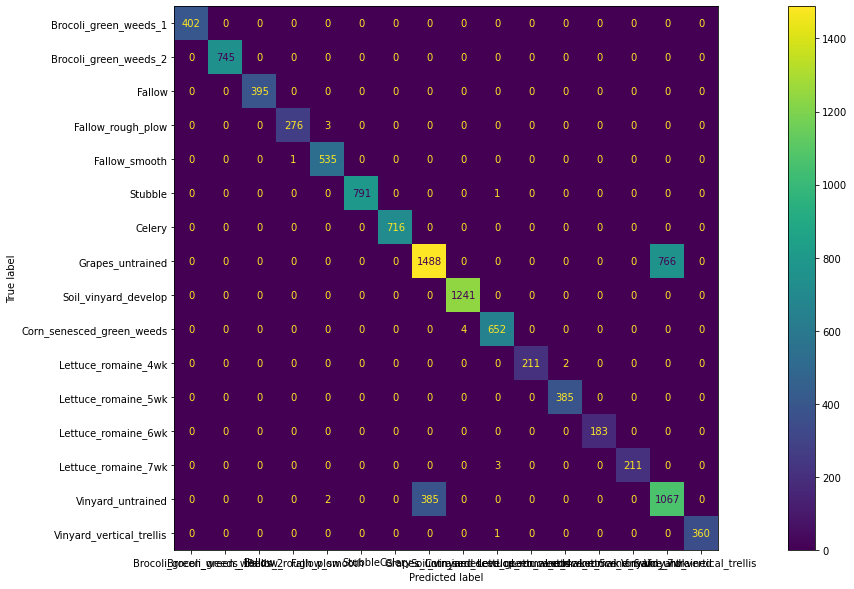

In [170]:
plot_classification_and_confusion_matrix(pipe_salinas, X1_test, Y1_test, classes_names_salinas)

0.8765853658536585
                              precision    recall  f1-score   support

                     Alfalfa       1.00      0.78      0.88         9
                 Corn-notill       0.81      0.87      0.84       286
                Corn-mintill       0.87      0.73      0.79       166
                        Corn       0.81      0.74      0.78        47
               Grass-pasture       0.94      0.97      0.95        97
                 Grass-trees       0.96      0.97      0.97       146
         Grass-pasture-mowed       1.00      1.00      1.00         5
               Hay-windrowed       0.99      1.00      0.99        96
                        Oats       1.00      1.00      1.00         4
              Soybean-notill       0.81      0.81      0.81       194
             Soybean-mintill       0.84      0.85      0.84       491
               Soybean-clean       0.86      0.85      0.86       119
                       Wheat       1.00      0.98      0.99        41


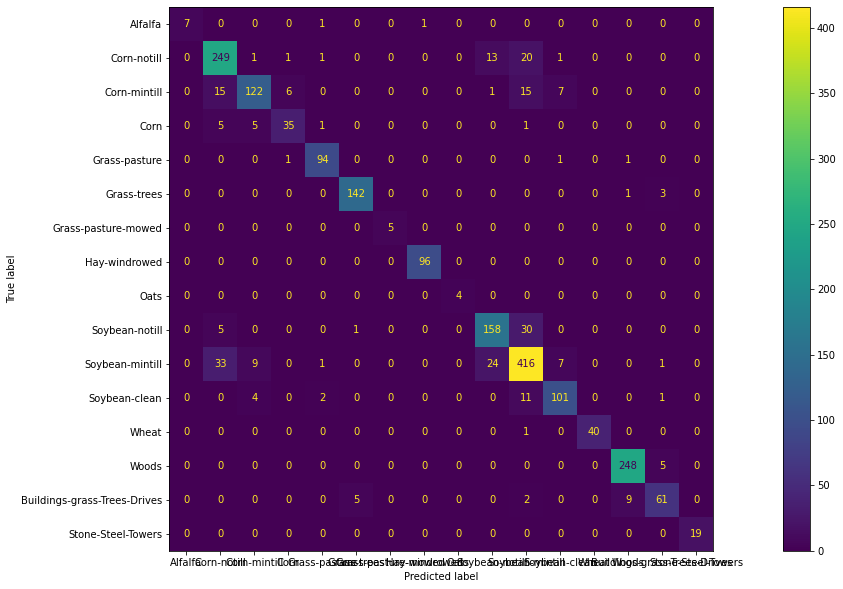

In [185]:
plot_classification_and_confusion_matrix(pipe_indianas, X2_test, Y2_test, classes_names_indiana_pines)

In [253]:
def reconstruct_image(ground_truth, prediction):
    original_img = ground_truth.flatten()
    indexes = np.array(np.where(original_img != 0))
    original_img[indexes] = prediction + 1
    return np.reshape(original_img, ground_truth.shape)


(array([ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16],
      dtype=uint8), array([56975,  2009,  3726,  1976,  1398,  2686,  3958,  3579,  9490,
        6225,  3259,  1067,  1930,   913,  1070,  9037,  1806]))
(array([ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16],
      dtype=uint8), array([56975,  2009,  3726,  1976,  1394,  2678,  3959,  3579, 11271,
        6203,  3278,  1068,  1927,   916,  1070,  7268,  1807]))
(array([ 1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16],
      dtype=uint8), array([2009, 3726, 1976, 1398, 2686, 3958, 3579, 9490, 6225, 3259, 1067,
       1930,  913, 1070, 9037, 1806]))
(array([ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16],
      dtype=uint8), array([56975,  2009,  3726,  1976,  1398,  2686,  3958,  3579,  9490,
        6225,  3259,  1067,  1930,   913,  1070,  9037,  1806]))


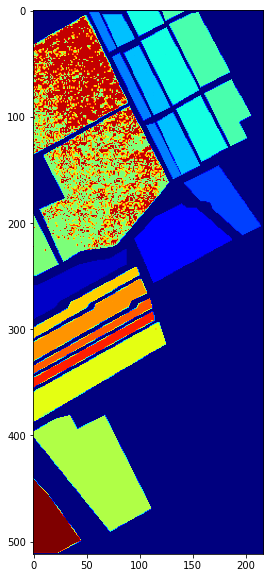

In [254]:
img = reconstruct_image(salinas_gt, y1_predict)
print(np.unique(img, return_counts=True))
print(np.unique(salinas_gt, return_counts=True))
print(np.unique(y1_predict + 1, return_counts=True))
print(np.unique(img, return_counts=True))

plt.figure(figsize=(10,10))
plt.imshow(img, cmap='jet')

In [266]:
def display_each_class(clf, X, ground_truth, name_classes, nb_col):
    name_classes_with_ground = name_classes.copy()
    name_classes_with_ground.insert(0, "Ground")
    y_predict = clf.predict(X)
    y_predict_reshaped = reconstruct_image(ground_truth, y_predict)
    
    nb_classes = np.size(name_classes_with_ground)
    nb_row = (nb_classes * 2 // nb_col) + 1
    print(nb_row, nb_col, nb_classes)
    index = 0
    plt.figure(figsize=(15,18))
    fig, axes = plt.subplots(nb_row, nb_col, figsize=(10,20))
    
    axes = axes.ravel()
    
    for i in range(nb_classes):
        axes[index].imshow(np.where(ground_truth != i, 1, 0), cmap="jet")
        axes[index].title.set_text(name_classes_with_ground[i])
        axes[index].set_xticklabels([])
        axes[index].set_yticklabels([])
        index += 1
        
        axes[index].imshow(np.where(y_predict_reshaped != i, 1, 0), cmap="jet")
        axes[index].set_xticklabels([])
        axes[index].set_yticklabels([])
        index += 1
    plt.show()
    

['Brocoli_green_weeds_1', 'Brocoli_green_weeds_2', 'Fallow', 'Fallow_rough_plow', 'Fallow_smooth', 'Stubble', 'Celery', 'Grapes_untrained', 'Soil_vinyard_develop', 'Corn_senesced_green_weeds', 'Lettuce_romaine_4wk', 'Lettuce_romaine_5wk', 'Lettuce_romaine_6wk', 'Lettuce_romaine_7wk', 'Vinyard_untrained', 'Vinyard_vertical_trellis']
(array([ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16],
      dtype=uint8), array([56975,  2009,  3726,  1976,  1398,  2686,  3958,  3579,  9490,
        6225,  3259,  1067,  1930,   913,  1070,  9037,  1806]))
(array([ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16],
      dtype=uint8), array([56975,  2009,  3726,  1976,  1394,  2678,  3959,  3579, 11271,
        6203,  3278,  1068,  1927,   916,  1070,  7268,  1807]))
6 6 17


<Figure size 1080x1296 with 0 Axes>

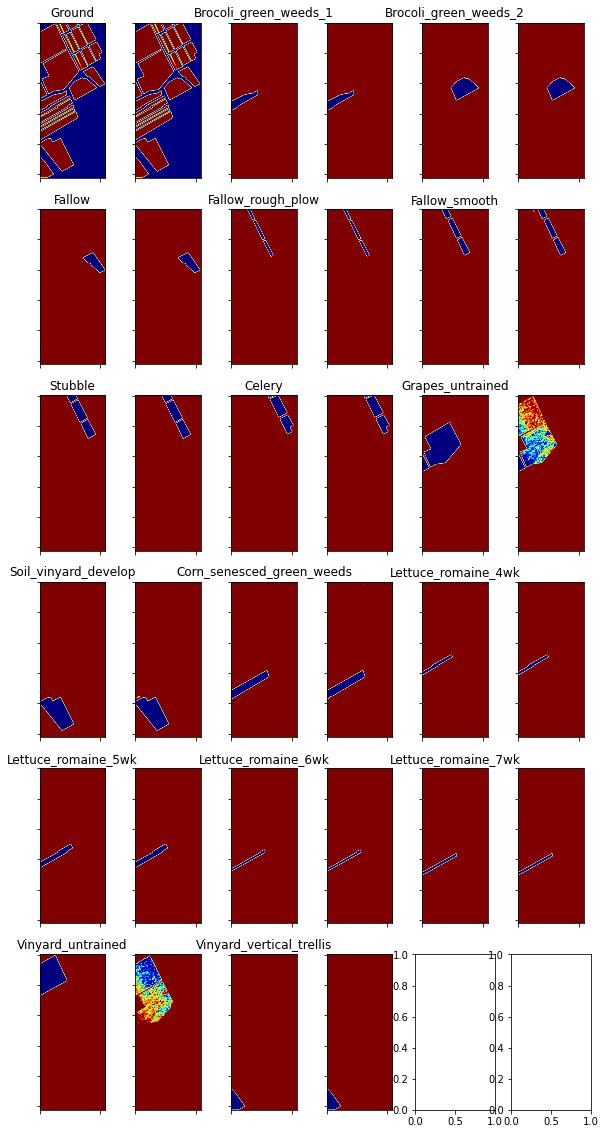

In [267]:
print(classes_names_salinas)
display_each_class(pipe_salinas, X1, salinas_gt, classes_names_salinas, nb_col=6)

In [149]:
from skimage.morphology import opening, closing
from skimage import morphology as morpho
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay, accuracy_score

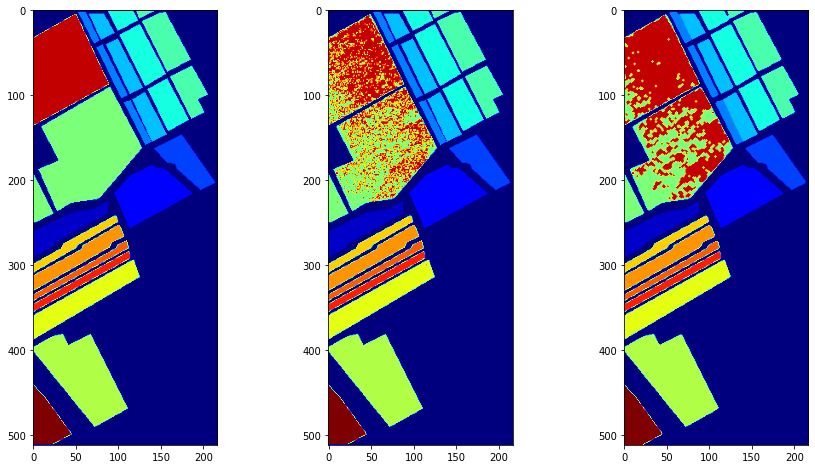

In [270]:
y1_predict = pipe_salinas.predict(X1)

reconstructed_img_salinas = reconstruct_image(salinas_gt, y1_predict)

y1_pred_rc = closing(reconstructed_img_salinas, morpho.diamond(1))
y1_pred_rc = opening(y1_pred_rc, morpho.diamond(1))

plt.figure(figsize=(15,8))
plt.subplot(131)
plt.imshow(salinas_gt, cmap='jet')

plt.subplot(132)
plt.imshow(reconstructed_img_salinas, cmap='jet')

plt.subplot(133)
plt.imshow(y1_pred_rc, cmap='jet')
plt.show()

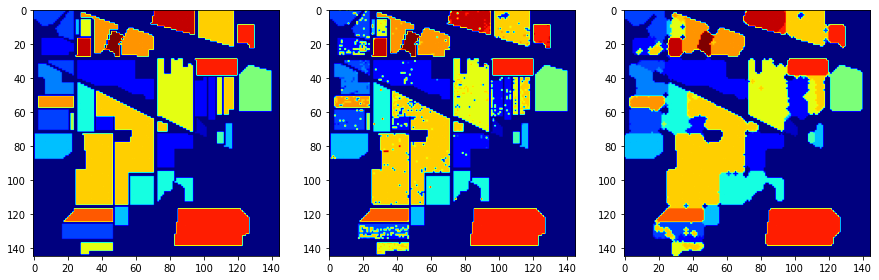

In [271]:
y2_predict = pipe_indianas.predict(X2)

reconstructed_img_indiana = reconstruct_image(indiana_pines_gt, y2_predict)

y2_pred_rc = closing(reconstructed_img_indiana, morpho.diamond(1))
y2_pred_rc = opening(y2_pred_rc, morpho.diamond(1))


plt.figure(figsize=(15,10))
plt.subplot(131)
plt.imshow(indiana_pines_gt, cmap='jet')

plt.subplot(132)
plt.imshow(reconstructed_img_indiana, cmap='jet')

plt.subplot(133)
plt.imshow(y2_pred_rc, cmap='jet')
plt.show()